# This notebook will plot the amplitudes and z scores of the data (in interactive modes and not), and let user choose potential thresholds for artifact removal

In [49]:
#import the normal things
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os
import numpy as np
import datajoint as dj
import scipy.stats as stats
# dj.config['database.host'] = '127.0.0.1'
# dj.config['database.user'] = 'root'
# dj.config['database.password']= 'simple'

In [51]:
import nwb_datajoint as nd

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
os.environ['NWB_DATAJOINT_TEMP_DIR']="/stelmo/nwb/tmp"
os.environ['KACHERY_STORAGE_DIR']="/stelmo/nwb/kachery-storage"

In [52]:
from nwb_datajoint.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  SortGroup, SpikeSortingFilterParameters, SpikeSortingArtifactDetectionParameters,
                                  SpikeSortingRecordingSelection, SpikeSortingRecording, 
                                  SpikeSortingWorkspace, 
                                  SpikeSorter, SpikeSorterParameters, SortingID,
                                  SpikeSortingSelection, SpikeSorting, 
                                  SpikeSortingMetricParameters,
                                  ModifySortingParameters, ModifySortingSelection, ModifySorting, 
                                  AutomaticCurationParameters, AutomaticCurationSelection,
                                  AutomaticCuration,
                                  CuratedSpikeSortingSelection, CuratedSpikeSorting,
                                  UnitInclusionParameters,
                                  FirFilter,
                                  IntervalList, SortInterval,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery)
import matplotlib.pyplot as plt
import statistics

In [53]:
#gather saved variables from last notebook
%store -r shape
%store -r session_data
%store -r data
%store -r dataz
%store -r recording
%store -r ssr_key
%store -r sort_interval_name
%store -r sort_interval



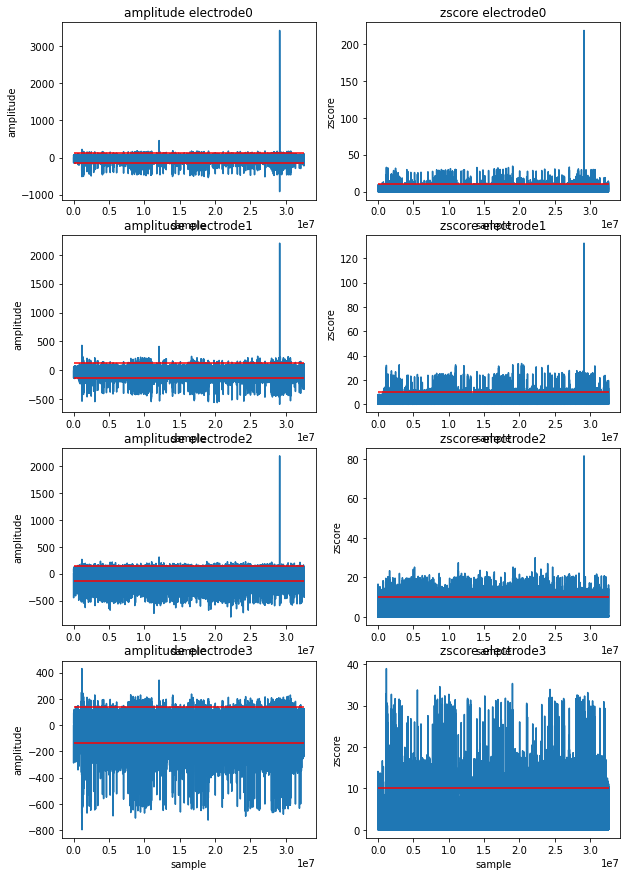

In [54]:
#plot both the amplitudes and z score data for all electrodes. Think about thresholds. Can add lines on there. 

# can change:
#     - int(shape[0]/2) - change how many electrodes are plotted. (processing power saver, half of 96 is fine for now)
#      -hlines- first value is threshold

%matplotlib inline
fig, axs = plt.subplots(int(shape[0]),2,figsize=(10,15))
# fig.suptitle(f'amp and z score all electrodes. {session_data}')
for ix in range(0,int(shape[0])):
#     plt.figure()
    amp_data_el = data[ix]
    zscore_data_el = dataz[ix]
    axs[ix,0].plot(amp_data_el)
    axs[ix,1].plot(zscore_data_el)
    axs[ix,0].set_title(f'amplitude electrode{ix}').set_fontsize(12)
    axs[ix,1].set_title(f'zscore electrode{ix}').set_fontsize(12)
    
    #uncomment if you want to try plotting some potential thresholds
    axs[ix,0].hlines(135,0,len(data[ix]),color='red')
    axs[ix,0].hlines(-135,0,len(data[ix]),color='red')


    axs[ix,1].hlines(10,0,len(dataz[ix]),color='r')
    axs[ix,0].set_ylabel('amplitude')
    axs[ix,1].set_ylabel('zscore')
    axs[ix,0].set_xlabel('sample')
    axs[ix,1].set_xlabel('sample')
    
#ugh hVing some problems with the title placement. like the idea of suplots too look at both z score and amplitude to decide thresholds. 
# fig.tight_layout()
# fig.subplots_adjust(top=1)

In [55]:
#plot each electrodes amplitude only- not as useful now that i made the subplots with both 
# for ix in range(shape[0]):
#     plt.figure()
#     data_1_row = data[ix,]
#     plt.plot(data_1_row)
#     plt.title(f'amplitude electrode {ix}\n {session_data}')
#     plt.ylabel('amplitude')
#     plt.xlabel('sample')
 # 



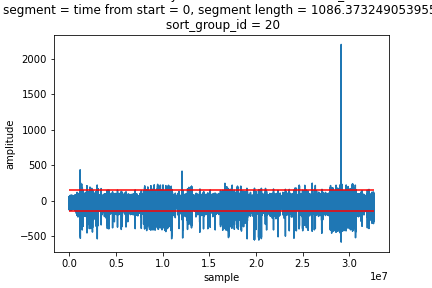

In [56]:
# plot interactive scrolling mode. likely a good idea to shorten interval for faster loading, but can also zoom in
%matplotlib widget
ix = 1
plt.figure()
data_1_row = data[ix]
plt.plot(data_1_row)
plt.title(f'electrode {ix},\n{session_data}')
plt.ylabel('amplitude')
plt.xlabel('sample')
thresh= 150
plt.hlines(thresh,0,len(data_1_row),color='r')
plt.hlines((-1*thresh),0,len(data_1_row),color='r')

In [57]:
# Lets fine which z scores realte to which amplitude


In [58]:
mean_amp = np.mean(data[0])

In [59]:
sd_amp = np.std(data[0])

In [60]:
mean_amp = np.mean(data[0])
sd_amp = np.std(data[0])
print(mean_amp)
print(sd_amp)

2.8818304e-05
15.741556


In [61]:
ix=10
amp_for_z = (ix*sd_amp + mean_amp)
amp_for_z

157.41559049432908

## Define some thresholds, prop electrodes artifact must cross on, how much to take out around the artifact
### This is just by eye for now, then we see how it did. 

In [62]:
# skip = False 
zscore_thresh = 10 #
amplitude_thresh=150
proportion_above_thresh = .9 #proportion of total electrodes the artifact has to cross. 
zero_window_len= .000005 #How many seconds around each artifact to remove. Easier for me to think about samples (this *1000*samplijng rate)
#also arbitrary for now, but should go back and recalculate after detection 


param_dict = {} #empty dictionary called param_dict
# param_dict['skip'] = skip
param_dict['zscore_thresh'] = zscore_thresh
param_dict['amplitude_thresh'] = amplitude_thresh
param_dict['proportion_above_thresh'] = proportion_above_thresh
param_dict['zero_window_len'] = zero_window_len # 1 ms at 30 KHz, but this is of course skipped

#we should define a variable called art_params that we can add to plots 

artifact_params = f'artifact params = z = {zscore_thresh} amp= {amplitude_thresh} prop = {proportion_above_thresh}'

In [63]:
#We define how many samples on each side of artifact we wil remove. 

#Say, 1ms on each side of the artifact, so zero window length == .002s
#Half window points will convert our time into samples on either side of the artifact. 
#.002 s
#Times 1000 = 2ms
#/2 = 1 ms
#*sampling frequency =~20,000 = 20,000 samples to be removed on either side of artifact 
# = half window points

half_window_points = np.round(recording.get_sampling_frequency() * 1000 * zero_window_len / 2)


print(half_window_points) #how many samples of data around each artifact (per side) to be removed
print(half_window_points/(recording.get_sampling_frequency()*1000)) # = how many s of data around each artifact will be removed



75.0
2.5033950805664062e-06


In [64]:
#number of electrodes that must be above threshold for artifact to count
nelect_above = np.round(proportion_above_thresh * data.shape[0])
# print(nelect_above)
print(nelect_above)

4.0


In [65]:
#calculated twice, from two different sources of data size
nelect_above = np.round(proportion_above_thresh * len(recording.get_channel_ids()))
print(nelect_above)

4.0


In [66]:
#Find indexes when amplitude is or is not crossing threshold for each electrode
above_a = np.abs(data) > amplitude_thresh
print(above_a)



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [67]:
#same for z score
dataz = np.abs(stats.zscore(data, axis=1))
above_z = dataz > zscore_thresh #find when datas z scare is above specified threshold
# print(dataz)
# print(above_z)

In [68]:
#above both: find when above z and above a are both true. Then, sum across electrodes for each sample. Find when sum > number electrodes. Find the timestamps when this occurs, and then "ravel" the array of times into 1 array
above_both = np.ravel(np.argwhere(np.sum(np.logical_and(above_z, above_a), axis=0) >= nelect_above))
valid_timestamps = recording._timestamps 
above_both
# valid_timestamps
#time delta, or more human readable python datetime- functions to work back and forth. better for rats with diff sampling rates. 

array([ 1170682,  1189575,  1189576,  1202273,  1352444,  1398691,
        1408827,  1408828,  1430245,  1438970,  1438971,  1438972,
        1449320,  1458277,  1467966,  1467967,  1467968,  1647524,
        1647525,  1903847,  1903848,  1906137,  1940168,  1970703,
        1970704,  1970705,  2216893,  2216894,  2216895,  2225304,
        2630759,  3043107,  3438601,  3781111,  3795823,  3795824,
        3967257,  3967258,  4058497,  4058498,  4064868,  4064869,
        4239859,  4500035,  5574294,  5574295,  5683203,  5683204,
        7666903,  7666904,  8152954,  8152955,  8152956,  8298713,
        8299233,  8299234,  8740083,  8740084,  8759337,  8769658,
        8769659,  8769660,  8775552,  9453474,  9453475,  9462516,
        9462517,  9545444,  9938168, 10059730, 10140207, 10332508,
       10344772, 10344773, 10344774, 10369486, 10525574, 10534076,
       10534077, 10534078, 10620113, 10620114, 10626916, 10626917,
       10626918, 10626919, 10629690, 10636022, 10951496, 10966

## Turn the timestamps corresponding to artifact to -1s 

In [69]:
for a in above_both:
    valid_timestamps[int(a - half_window_points):int(a + half_window_points)] = -1
#Section for vizualizing/ examining timestamps below!!

In [70]:
# find and return valid intervals. Not as useful for quantifying artifact 

# get_valid_intervals(valid_timestamps[valid_timestamps != -1], recording.get_sampling_frequency(), 1.5, 0.001)

#is this the second chunk of data? Is this the only thing thats getting used from first chunk? 
#two second parameters? gap length? 

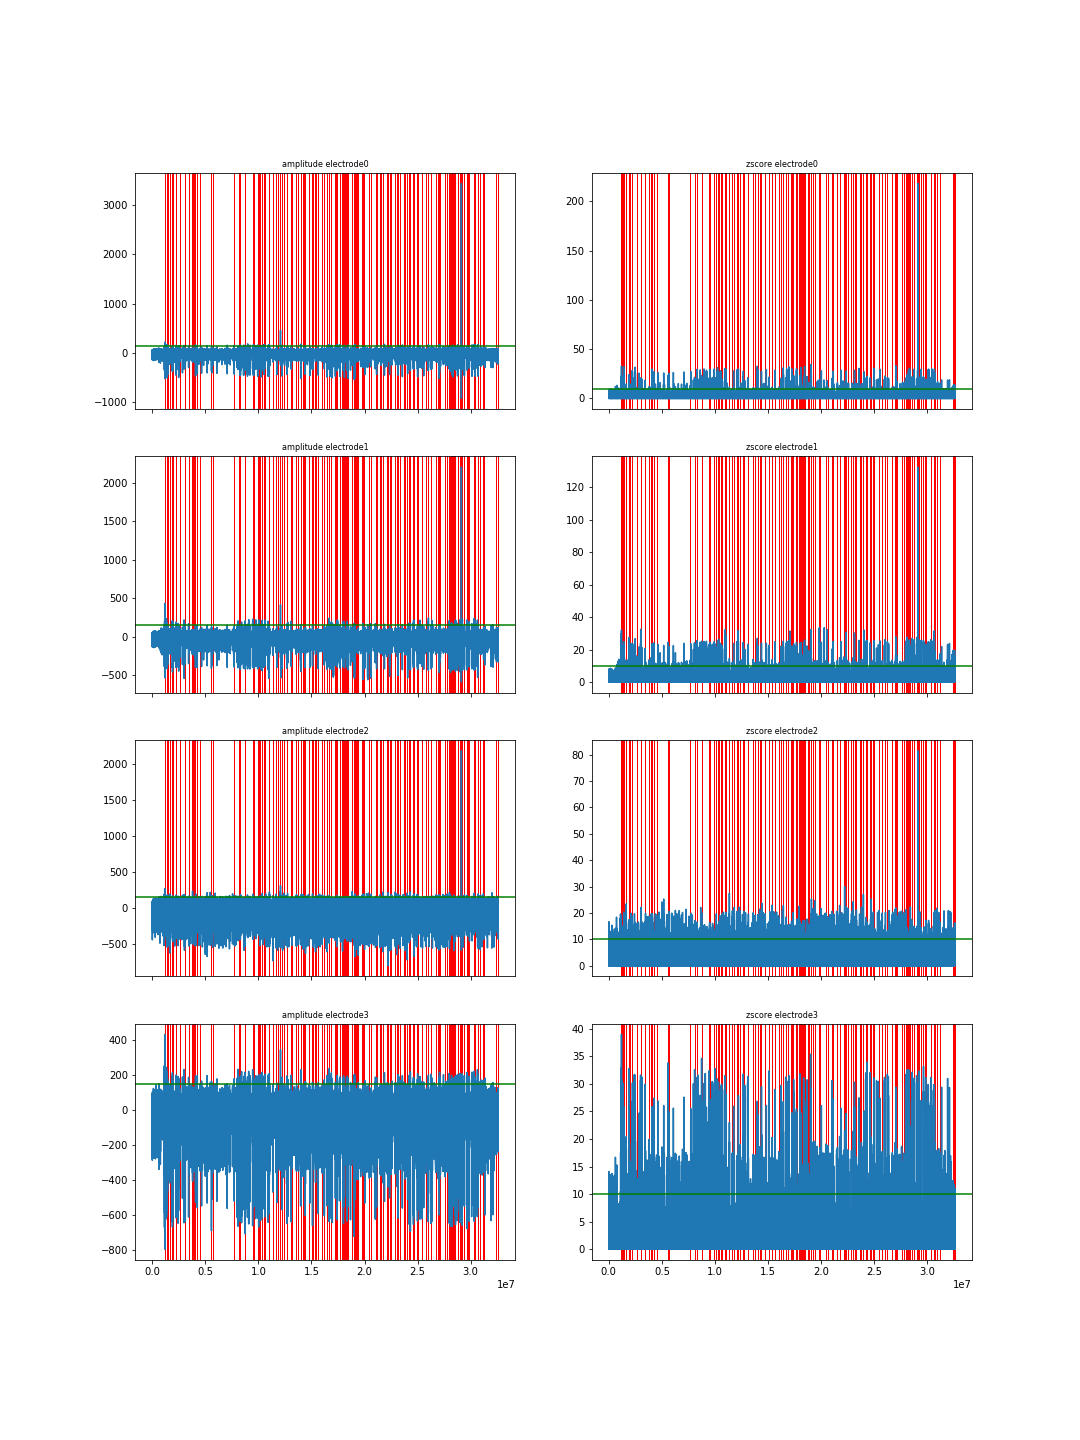

In [71]:
fig, axs = plt.subplots(int(shape[0]),2,figsize=(15,20), sharex=True)
# fig.suptitle(f'amp and z score all electrodes. {session_data}')
for ix in range(0,int(shape[0])):
#     plt.figure()
    amp_data_el = data[ix]
    zscore_data_el = dataz[ix]
    axs[ix,0].plot(amp_data_el)
    for a in above_both:
        axs[ix,0].axvspan(int(a - half_window_points),int(a + half_window_points), color='red', label='detected artifact times')
    axs[ix,1].plot(zscore_data_el)
    for a in above_both:
        axs[ix,1].axvspan(int(a - half_window_points),int(a + half_window_points), color='red', label='detected artifact times')
    axs[ix,0].set_title(f'amplitude electrode{ix}').set_fontsize(8)
    axs[ix,1].set_title(f'zscore electrode{ix}').set_fontsize(8)
    axs[ix,0].axhline(amplitude_thresh,0,len(data[ix]), color ='green')
    axs[ix,1].axhline(zscore_thresh,0,len(dataz[ix]),color ='green')
    #ylabel

#little stuff: 
#axis labeling, legends (even though it may be diff in subplotting)


In [72]:
%store valid_timestamps
%store above_both
%store above_z
%store above_a
%store nelect_above
%store half_window_points
%store artifact_params
%store param_dict



Stored 'valid_timestamps' (ndarray)
Stored 'above_both' (ndarray)
Stored 'above_z' (ndarray)
Stored 'above_a' (ndarray)
Stored 'nelect_above' (float64)
Stored 'half_window_points' (float64)
Stored 'artifact_params' (str)
Stored 'param_dict' (dict)
